# **Imports and setup**

In [88]:
import pandas as pd
import numpy as np

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import random

from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

In [94]:
df = pd.read_csv('urban_demand.csv')
og_series = df.iloc[:2000,1]
series_length = len(og_series)

In [132]:
df = pd.read_csv('wave_height.csv')
og_series = df.iloc[:2000,0]
series_length = len(og_series)

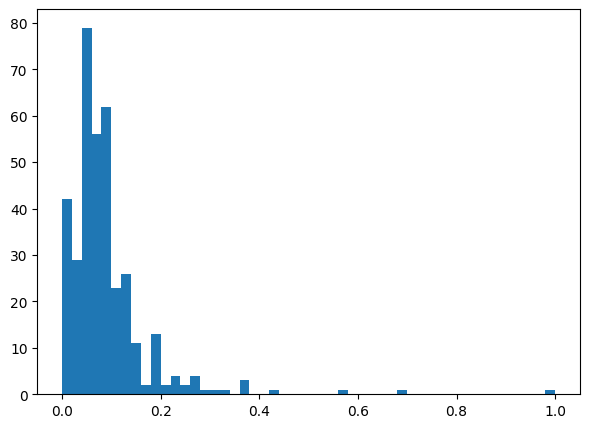

In [148]:
df = pd.read_csv('NO.csv')
og_series = df.iloc[:,1]
series_length = len(og_series)

scaler = MinMaxScaler(feature_range=(0, 1))
normalized_series = scaler.fit_transform(og_series.array.reshape(-1,1))[:,0]
plt.hist(normalized_series,bins=50)
plt.show()

# Not so good results so far - more work to be done here

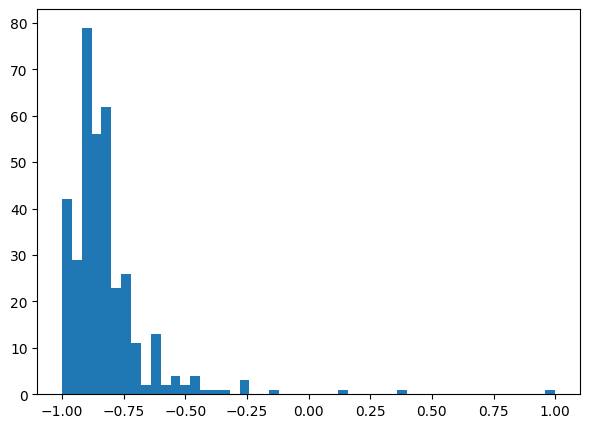

In [143]:
# Data Scaliing
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized_series = scaler.fit_transform(og_series.array.reshape(-1,1))[:,0]
plt.hist(normalized_series,bins=50)
plt.show()

In [134]:
# Dataset

class og_Dataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = np.expand_dims(self.data[index:index+self.window], -1)
        return torch.from_numpy(x).float()

    def __len__(self):
        return len(self.data) - self.window

## **Original paper Preprocessing**

In [23]:
og_log = np.log(og_series / og_series.shift(1))[1:].values

We see thick tails of distribution:

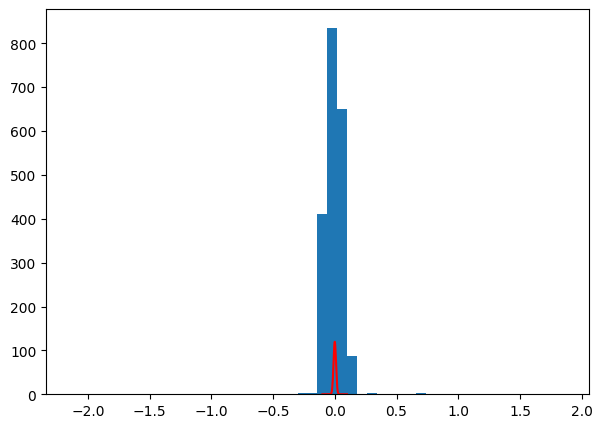

In [24]:
plt.hist(og_log, bins=50)
x_axis = np.arange(-0.1, 0.1, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.01) * 3, color= 'r')
plt.show()

Perform an inverse Lambert transformation and re-normalization using IGMM algorithm.


In [26]:
def delta_init(z):
    k = kurtosis(z, fisher=False, bias=False)
    if k < 166. / 62.:
        return 0.01
    return np.clip(1. / 66 * (np.sqrt(66 * k - 162.) - 6.), 0.01, 0.48)

def delta_gmm(z):
    delta = delta_init(z)

    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k

    res = fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

def W_delta(z, delta):
    return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)

def W_params(z, params):
    return params[0] + params[1] * W_delta((z - params[0]) / params[1], params[2])

def inverse(z, params):
    return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))

def igmm(z, eps=1e-6, max_iter=100):
    delta = delta_init(z)
    params = [np.median(z), np.std(z) * (1. - 2. * delta) ** 0.75, delta]
    for k in range(max_iter):
        params_old = params
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm(u)
        x = W_params(z, params)
        params[0], params[1] = np.mean(x), np.std(x)

        if np.linalg.norm(np.array(params) - np.array(params_old)) < eps:
            break
        if k == max_iter - 1:
            raise "Solution not found"

    return params

og_log_mean = np.mean(og_log)
og_log_norm = og_log - og_log_mean
params = igmm(og_log_norm)
og_processed = W_delta((og_log_norm - params[0]) / params[1], params[2])
og_max = np.max(np.abs(og_processed))
og_processed /= og_max

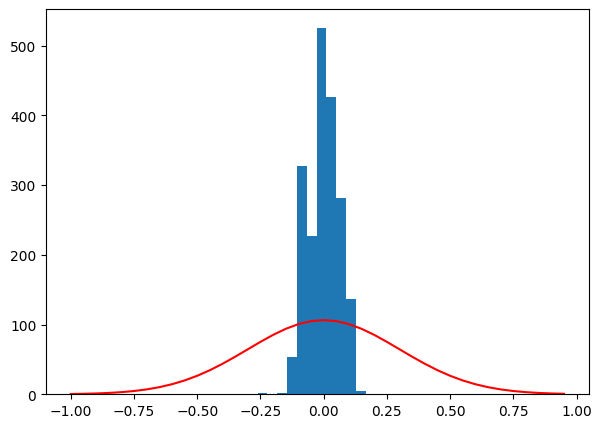

In [27]:
plt.hist(og_processed, bins=50)
x_axis = np.arange(-1, 1, 0.05)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.3) * 80, color= 'r')
plt.show()

In [28]:
# Dataset

class og_Dataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = np.expand_dims(self.data[index:index+self.window], -1)
        return torch.from_numpy(x).float()

    def __len__(self):
        return len(self.data) - self.window

# **Models for GAN**

In [29]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_hidden, kernel_size, stride=1, dilation=dilation, padding='same')

        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(n_hidden, n_outputs, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu2 = nn.PReLU()

        self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=80):
        super(TCN, self).__init__()
        layers = []
        for i in range(7):
            num_inputs = input_size if i == 0 else n_hidden
            kernel_size = 2 if i > 0 else 1
            dilation = 2 * dilation if i > 1 else 1
            layers += [TemporalBlock(num_inputs, n_hidden, n_hidden, kernel_size, dilation)]
        self.conv = nn.Conv1d(n_hidden, output_size, 1)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        self.conv.weight.data.normal_(0, 0.01)

    def forward(self, x):
        y1 = self.net(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)

class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.tanh(self.net(x))

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.net(x))

# **Prepare and train GAN**

In [146]:
clip_value = 0.01
lr = 2e-4 #0.0002
num_epochs = 100
nz = 3
batch_size = 30
seq_len = 127

netG = Generator(nz, 1).to(device)
netD = Discriminator(1, 1).to(device)
optD = optim.RMSprop(netD.parameters(), lr=lr)
optG = optim.RMSprop(netG.parameters(), lr=lr)

dataset = og_Dataset(normalized_series, 127) # SCALED ORIG. DATASET
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
t = tqdm(range(num_epochs))
for epoch in t:
    for i, data in enumerate(dataloader, 0):

        netD.zero_grad()
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        fake = netG(noise).detach()

        lossD = -torch.mean(netD(real)) + torch.mean(netD(fake))
        lossD.backward()
        optD.step()

        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)

        if i % 5 == 0:
            netG.zero_grad()
            lossG = -torch.mean(netD(netG(noise)))
            lossG.backward()
            optG.step()
    #Report metrics
    t.set_description('Loss_D: %.8f Loss_G: %.8f' % (lossD.item(), lossG.item()))

    # Checkpoint
    torch.save(netG, 'quantGAN_netG_epoch_%d.pth' % epoch)
    torch.save(netD, 'quantGAN_netD_epoch_%d.pth' % epoch)


Loss_D: -0.00000083 Loss_G: -0.49756134: 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


#**Probe generation**

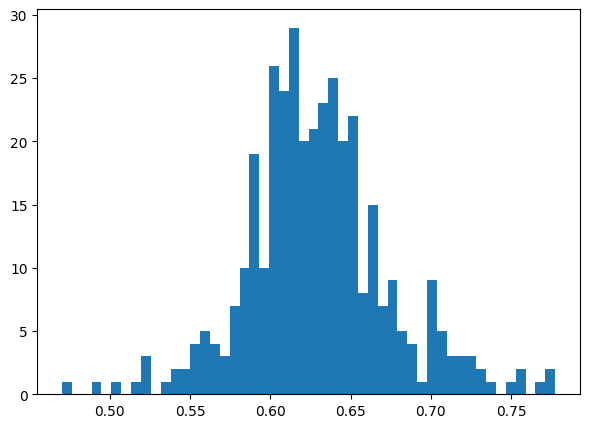

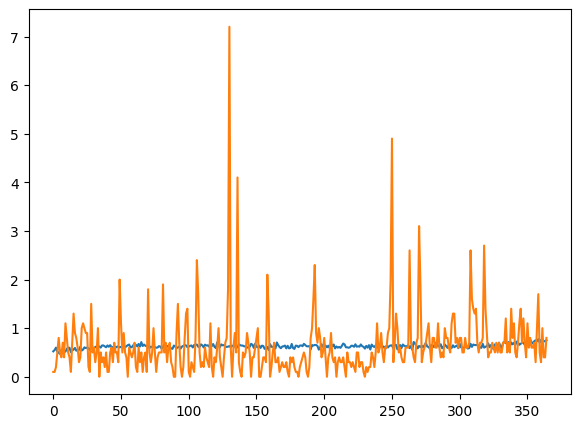

In [147]:
noise = torch.randn(1, series_length, nz, device=device)
synth_series = netG(noise).detach().cpu().reshape(series_length).numpy()

synth_series = np.reshape(synth_series, (-1,1))
synth_series_adj = scaler.inverse_transform(synth_series)

plt.hist(synth_series_adj, bins=50)
plt.show()
plt.plot(synth_series_adj)
plt.plot(og_series)
plt.show()

In [ ]:
#!pip freeze > requirements.txt